In [2]:
import sys
import numpy as np
import geopandas as gpd
import fiona
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from adcircutils.channelmodeling.NCFRISCrossSect2Depth import NCFRISCrossSect2Depth
# from NHDArea2Width import NHDArea2Width

ModuleNotFoundError: No module named 'adcircutils.channelmodeling.NCFRISCrossSect2Depth'

In [2]:
geotiff_files = [
    "/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/DEM_NCFRIS_LaurenGrimley/dep_subgrid_edited.tif",
    # "/mnt/d/work/gis_data/CUDEM_merged/ncei_nintharcsec_dem_J890665_merged.tif",
    # # "/mnt/d/work/gis_data/CUDEM/ncei_nintharcsec_dem_J890665_000_000.tif",
    # "/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/CoNED/North_Carolina_CoNED_TBDEM_version_2.0/North_Carolina_CoNED_Topobathy_DEM_1m_version_20.tif",
    # # "/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/USGS_DEM/USGS_13_n37w078_20210610.tif",
    # # "/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/USGS_DEM/USGS_13_n36w078_20151125.tif",
]

# nhdarea_shpfiles = [
#     ["/home/sbunya/OneDriveDocuments/gis_data/NC/NHDPLUS_H_0301_HU4_GDB.zip", "NHDArea"],
#     ["/home/sbunya/OneDriveDocuments/gis_data/NC/NHDPLUS_H_0302_HU4_GDB.zip", "NHDArea"],
#     ["/home/sbunya/OneDriveDocuments/gis_data/NC/NHDPLUS_H_0301_HU4_GDB/NHDPLUS_H_0301_HU4_GDB_a44_WaterArea.shp", None],
# ]

nhdarea_shpfiles = [
    ["/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/NHDPLUS_H_0302_HU4_WaterArea_Edited.geojson", None],
]

nhdarea_shpfiles_for_tar = [
    ["/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/NHDPLUS_H_0302_HU4_WaterArea_Edited2.geojson", None],
]

nhdarea_shpfiles_for_roanoke = [
    ["/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/NHDPLUS_H_0301_HU4_WaterArea_Edited_Roanoke.gpkg", None],
]

nhdplusids = [15000400157779, 15000400158249, 15000100190768, 15000400158098, 15000400158152, 15000400158048,
              15000400157779, 15000400157733, 15000400158267, 15000400158210, # Tar
              15000400158078, 15000400158079, 15000400158508, 15000400158305, # Harlowe
              15000400158301, # Adam
              15000100161039, # Alligator
              15000400158375, 15000400157953, # New
              15000400158212, 15000400157779, 15000400158205, # Pamlico-Gale
]

nhdplusids_roanoke = [15000100190528, 15000100151158, 15000100165945]

In [95]:
def NCFRISCrossSections2FlowlineDepth(gdf_xsect, gdf_hydra, flowlines_file, area_coverage_file, flowlines_output_file, crs_utm):
    # Obtain flowlines
    gdf_flowlines = gpd.read_file(flowlines_file)

    # Obtain area coverage
    area_coverage = gpd.read_file(area_coverage_file).to_crs(crs_utm)

    # Obtain reduced versions of gdf_xsect and gdf_hydra
    if gdf_xsect.crs:
        gdf_xsect = gdf_xsect.to_crs(crs_utm)
    else:
        gdf_xsect = gdf_xsect.set_crs('epsg:2264').to_crs(crs_utm)
    if gdf_hydra.crs:
        gdf_hydra = gdf_hydra.to_crs(crs_utm)
    else:
        gdf_hydra = gdf_hydra.set_crs('epsg:2264').to_crs(crs_utm)
    gdf_flowlines = gdf_flowlines.to_crs(crs_utm)
    
    
    # Reduce gdf_xsect and gdf_hydra to only those within the convex hull of gdf_flowlines
    gdf_xsect_reduced = gdf_xsect[area_coverage.union_all().contains(gdf_xsect.geometry) | area_coverage.union_all().overlaps(gdf_xsect.geometry)]
    gdf_hydra_reduced = gdf_hydra[area_coverage.union_all().contains(gdf_hydra.geometry) | area_coverage.union_all().overlaps(gdf_hydra.geometry)]

    # Create pt_depth along flowlines from NCFRIS cross-sections
    ft2m = 0.3048
    gdf_flowlines['pt_depth'] = None
    for ifl in gdf_flowlines.index:
        fl = gdf_flowlines.loc[ifl]

        # Create segments from the LineString fl
        segments = [LineString([fl.geometry.coords[i], fl.geometry.coords[i + 1]]) for i in range(len(fl.geometry.coords) - 1)]

        # Create a GeoDataFrame from the segments
        gdf_segments = gpd.GeoDataFrame(geometry=segments, crs=crs_utm)

        # Identify the indexes of the crosssections in gdf_xsect that cross segments in LineString fl
        pt_dists = np.zeros(len(gdf_segments)+1)
        intersect_dists = []
        intersect_bed_elevs = []
        for i, segment in enumerate(gdf_segments.geometry):
            pt_dists[i+1] = pt_dists[i] + segment.length
            contains = gdf_hydra_reduced.contains(segment.centroid)
            if np.any(contains):
                if np.count_nonzero(contains) > 1:
                    raise ValueError("More than one HYDRAID contains the segment")
                target_hydraid = gdf_hydra_reduced[contains].HYDRAID.values[0]
                gdf_xsect_target = gdf_xsect_reduced[gdf_xsect_reduced.HYDRAID == target_hydraid]
                intersects = gdf_xsect_target.intersects(segment)
                if np.any(intersects):
                    intersection_points = gdf_xsect_target[intersects].intersection(segment)
                    if len(intersection_points) == 0:
                        raise ValueError("No intersection point")
                    for point in intersection_points:
                        bed_elev = gdf_xsect_target.loc[gdf_xsect_target[intersects].index, 'BED_ELEV'].values[0]
                        if bed_elev == -8888:
                            continue
                        dist = pt_dists[i] + segment.project(point)
                        intersect_dists.append(dist)
                        intersect_bed_elevs.append(bed_elev*ft2m)

        if len(intersect_dists) == 0:
            pt_depth = ','.join(['-99999.0'] * len(pt_dists))
        else:
            interpolated_bed_elevs = np.interp(pt_dists, intersect_dists, intersect_bed_elevs)
            pt_depth = ','.join([f'{val:.2f}' for val in interpolated_bed_elevs])

        gdf_flowlines.loc[ifl, 'pt_depth'] = pt_depth
        
    gdf_flowlines.to_file(flowlines_output_file)

In [3]:
# Roanoke========================================================================
target_name = 'Roanoke'
flowline_shpfile_prefix = '/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/nhdp_hr_roanoke_4'
dp_flowline_shpfile = flowline_shpfile_prefix + ".geojson"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data_tmp.geojson"
area_coverage_file = '/mnt/d/work/EmbedVEW1DtoLargeModel/meshes/Roanoke/roanoke_area_coverage.geojson'

In [4]:
# - Depth parameters
ncfriscrosssections_gdbfile = "/mnt/d/work/EmbedVEW1DtoLargeModel/gis_data/NCFRIS_FROM_LGrimley/NCEM_Shapefiles_From_LGrimley/uncRequest09142022.gdb"
# crs_utm = 'epsg:32617'

# # Obtain cross-sections
# with fiona.open(ncfriscrosssections_gdbfile, layer='V_E_HYDRACROSSSECTION') as src:
#     gdf_xsect = gpd.GeoDataFrame.from_features(src)

# # Obtain Hydra Model domains
# with fiona.open(ncfriscrosssections_gdbfile, layer='V_E_HYDRAMODEL') as src:
#     gdf_hydra = gpd.GeoDataFrame.from_features(src)

In [5]:
# - Add depth to flowline shapefile
# NCFRISCrossSections2FlowlineDepth(gdf_xsect, gdf_hydra, dp_flowline_shpfile, area_coverage_file, dp_output_file, crs_utm)
NCFRISCrossSect2Depth(ncfriscrosssections_gdbfile, dp_flowline_shpfile, area_coverage_file, dp_output_file)

'3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.17,3.14,3.15,3.14,3.12,3.09,3.07,3.05,3.04,3.02,3.01,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00'

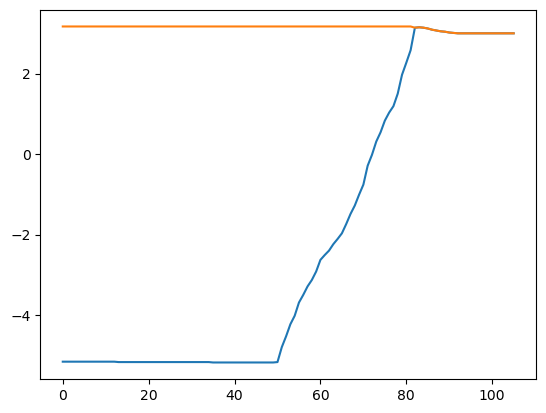

In [28]:
depths = [-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.16,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.17,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.18,-5.17,-4.80,-4.53,-4.23,-4.02,-3.69,-3.50,-3.29,-3.13,-2.92,-2.63,-2.51,-2.40,-2.24,-2.11,-1.97,-1.74,-1.49,-1.28,-1.01,-0.76,-0.29,-0.02,0.31,0.54,0.83,1.03,1.19,1.50,1.97,2.27,2.58,3.14,3.15,3.14,3.12,3.09,3.07,3.05,3.04,3.02,3.01,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00]
depths_new = [v if v > 2.99 else 3.17 for v in depths]
plt.plot(depths)
plt.plot(depths_new)
','.join(['{:.2f}'.format(val) for val in depths_new])

'32.06,32.13,32.21,32.31,32.41,32.85,32.85,33.75,35.12,37.52,41.21,44.31,45.66,47.30,48.02,48.02,48.02,48.02,48.02,46.91,45.70,43.57,41.62,41.62,41.62,41.62,41.62,43.59,47.63,52.75,56.56,56.56,56.56,56.56,56.56,55.51,53.58,52.16,51.49,51.49,51.49,51.49,51.11,51.11,51.11,50.94,50.12,48.64,48.06,47.62,47.26,47.26,47.26,47.26,47.42,47.86,49.14,49.14,49.05,50.39,50.92,51.20,51.50,51.92,54.59,57.84,59.67,61.09,61.69,62.42,62.42,62.42,62.14,63.61,64.72,65.14,65.14,65.14,64.76,64.68,64.68,64.68,64.68,62.98,62.98,62.98,62.98,62.98,63.32,68.73,73.92,74.61,74.61,74.61,74.61,74.61,73.73,72.87,70.38,66.17,63.28,62.16,61.32,58.83,56.46,56.25,56.01,56.01,56.01,56.01,56.25,57.32,59.03,60.74,62.06,62.83,64.11,64.91,65.18,65.44,65.84,68.35,70.54,70.54,70.98,71.16,71.16,71.16,71.16,70.52,69.72,68.28,66.62,65.69,64.94,64.47,64.47,64.47,64.47,64.47,64.87,69.17,72.71,73.03,73.44,73.44,73.44,73.44,72.83,72.83,72.83,74.04,75.53,74.04,72.51,72.56,72.56,72.56,72.56,72.24,71.98,71.67,70.27,65.25,60.26,59.47,59.

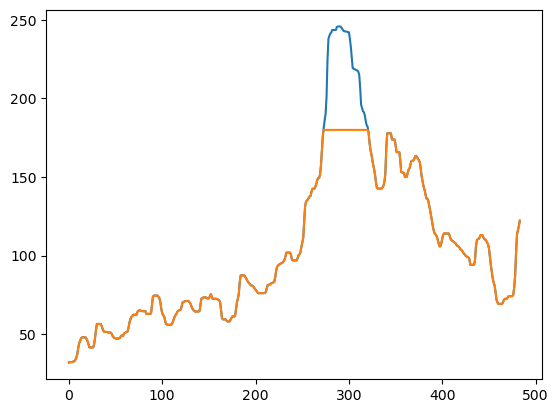

In [104]:
widths = [32.06,32.13,32.21,32.31,32.41,32.85,32.85,33.75,35.12,37.52,41.21,44.31,45.66,47.30,48.02,48.02,48.02,48.02,48.02,46.91,45.70,43.57,41.62,41.62,41.62,41.62,41.62,43.59,47.63,52.75,56.56,56.56,56.56,56.56,56.56,55.51,53.58,52.16,51.49,51.49,51.49,51.49,51.11,51.11,51.11,50.94,50.12,48.64,48.06,47.62,47.26,47.26,47.26,47.26,47.42,47.86,49.14,49.14,49.05,50.39,50.92,51.20,51.50,51.92,54.59,57.84,59.67,61.09,61.69,62.42,62.42,62.42,62.14,63.61,64.72,65.14,65.14,65.14,64.76,64.68,64.68,64.68,64.68,62.98,62.98,62.98,62.98,62.98,63.32,68.73,73.92,74.61,74.61,74.61,74.61,74.61,73.73,72.87,70.38,66.17,63.28,62.16,61.32,58.83,56.46,56.25,56.01,56.01,56.01,56.01,56.25,57.32,59.03,60.74,62.06,62.83,64.11,64.91,65.18,65.44,65.84,68.35,70.54,70.54,70.98,71.16,71.16,71.16,71.16,70.52,69.72,68.28,66.62,65.69,64.94,64.47,64.47,64.47,64.47,64.47,64.87,69.17,72.71,73.03,73.44,73.44,73.44,73.44,72.83,72.83,72.83,74.04,75.53,74.04,72.51,72.56,72.56,72.56,72.56,72.24,71.98,71.67,70.27,65.25,60.26,59.47,59.47,59.47,59.47,58.67,58.14,58.14,58.14,59.00,60.22,61.26,61.33,61.33,61.55,66.10,70.27,72.64,75.77,83.09,87.44,87.44,87.44,87.44,87.44,86.44,85.50,84.25,83.13,82.63,81.72,81.02,81.02,80.73,80.09,79.14,78.35,77.51,76.59,76.15,76.15,76.14,76.14,76.14,76.14,76.14,76.34,77.02,79.35,81.33,81.51,81.54,81.98,82.50,82.69,83.00,83.46,86.19,90.42,92.83,93.74,94.29,94.69,95.00,95.31,95.63,96.39,97.41,99.52,101.91,101.91,101.91,101.91,101.91,100.19,97.34,96.97,96.97,96.97,96.97,96.97,98.41,100.30,100.87,102.11,105.44,108.36,111.17,120.85,131.36,134.36,134.97,135.85,136.76,137.77,138.09,141.03,142.58,142.58,142.58,143.75,145.61,148.05,149.39,149.39,151.44,157.27,166.36,176.07,181.57,186.24,190.28,201.32,224.51,237.92,239.77,241.30,241.84,243.52,243.52,243.52,243.52,243.52,245.41,245.79,245.79,245.79,245.79,245.06,244.06,243.19,242.68,242.68,242.56,242.43,242.11,242.11,237.86,232.91,225.75,219.28,218.90,218.64,218.32,218.02,217.66,217.04,215.06,206.79,196.08,193.84,191.86,191.32,189.22,185.59,182.90,181.95,178.45,171.93,167.46,164.65,161.16,157.60,154.79,151.09,146.37,143.08,142.67,142.67,142.67,142.67,142.67,143.44,144.55,146.96,152.29,168.86,177.83,177.83,177.83,177.83,177.83,173.89,173.89,173.89,173.89,170.11,165.86,165.86,165.86,165.86,160.43,153.09,153.09,152.68,152.68,150.01,150.01,150.22,152.89,154.88,155.74,158.33,160.27,160.27,160.57,161.60,163.30,163.44,162.62,161.60,160.57,159.23,154.65,150.03,146.97,143.74,141.89,138.92,136.37,136.23,134.86,131.95,128.70,125.38,121.79,118.16,115.57,113.84,113.38,112.24,110.41,107.93,105.95,105.95,107.93,111.08,113.38,114.23,114.10,114.10,114.10,114.10,114.10,112.48,110.55,109.70,109.44,108.88,108.33,107.98,107.10,106.22,105.92,105.54,104.60,103.60,103.33,102.41,101.33,100.83,99.94,99.35,99.26,98.87,97.89,94.20,94.20,94.20,94.20,94.20,97.02,105.74,109.58,110.54,110.66,111.65,113.12,113.12,113.12,111.55,110.54,110.38,109.52,108.43,107.22,104.50,99.24,93.93,89.51,85.56,82.87,81.04,76.94,72.16,70.30,69.36,69.36,69.36,69.36,69.36,70.23,71.88,72.54,72.54,72.61,73.42,74.22,74.22,74.22,74.22,74.26,75.01,79.84,87.36,102.03,113.45,116.13,118.82,122.23]
widths_new = np.min([widths, [180]*len(widths)], axis=0)
plt.plot(widths)
plt.plot(widths_new)
','.join(['{:.2f}'.format(val) for val in widths_new])


In [103]:
# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 5

wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles_for_roanoke, nhdplusids_roanoke, default_width, min_width, max_width, median_window, wd_output_file)

Processing WD for Roanoke
Now at 1/814
No intersection found at (jl, il) = (0, 0)
No intersection found at (jl, il) = (0, 1)
No intersection found at (jl, il) = (0, 2)
No intersection found at (jl, il) = (0, 3)
No intersection found at (jl, il) = (0, 4)
No intersection found at (jl, il) = (0, 5)
No intersection found at (jl, il) = (0, 6)
No intersection found at (jl, il) = (0, 7)
No intersection found at (jl, il) = (0, 8)
No intersection found at (jl, il) = (0, 9)
No intersection found at (jl, il) = (0, 10)
No intersection found at (jl, il) = (0, 11)
No intersection found at (jl, il) = (0, 12)
No intersection found at (jl, il) = (0, 13)
No intersection found at (jl, il) = (0, 14)
No intersection found at (jl, il) = (0, 15)
No intersection found at (jl, il) = (0, 16)
No intersection found at (jl, il) = (0, 17)
No intersection found at (jl, il) = (0, 18)
No intersection found at (jl, il) = (0, 19)
No intersection found at (jl, il) = (0, 20)
No intersection found at (jl, il) = (0, 21)
No 

In [ ]:
# - Add depth to flowline shapefile
NCFRISCrossSections2FlowlineDepth(ncfriscrosssections_gdbfile, dp_flowline_shpfile, dp_output_file, crs_utm)

In [ ]:
# Roanoke========================================================================
target_name = 'Roanoke'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/nhdp_hr_roanoke_2'
dp_flowline_shpfile = flowline_shpfile_prefix + ".gpkg"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0
depth_min = -100
nneipixel = 20
min_window = 5

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 5

# - Add depth to flowline shapefile
print('Processing DP for {}'.format(target_name))
DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles_for_tar, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# # Pantego =============================================================================
# target_name = 'Pantego'
# flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_pantego_v1'
# dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
# dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
# wd_flowline_file = dp_output_file
# wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# # - Depth parameters
# hydroflattened_depth = 0.0
# hydroflattened_depth_after_corrected = 0.0
# depth_min = 1.0
# nneipixel = 20
# min_window = 2

# # - Width parameters
# default_width = 5.0
# min_width = 5.0
# max_width = 10000.0
# median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# # - Add width to flowline shapefile
# print('Processing WD for {}'.format(target_name))
# NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# # Alligator Pungo =============================================================================
# target_name = 'Alligator Pungo'
# flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_alligator_pungo_trimmed_v2'
# dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
# dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
# wd_flowline_file = dp_output_file
# wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# # - Depth parameters
# hydroflattened_depth = 0.0
# hydroflattened_depth_after_corrected = 0.0
# depth_min = 1.0
# nneipixel = 20
# min_window = 2

# # - Width parameters
# default_width = 5.0
# min_width = 5.0
# max_width = 10000.0
# median_window = 2

# # # - Add depth to flowline shapefile
# # print('Processing DP for {}'.format(target_name))
# # DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# # - Add width to flowline shapefile
# print('Processing WD for {}'.format(target_name))
# NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# # Little =============================================================================
# target_name = 'Little'
# flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_little'
# dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
# dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
# wd_flowline_file = dp_output_file
# wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# # - Depth parameters
# hydroflattened_depth = 0.153
# hydroflattened_depth_after_corrected = 1.0
# depth_min = 1.0
# nneipixel = 20
# min_window = 2

# # - Width parameters
# default_width = 5.0
# min_width = 5.0
# max_width = 10000.0
# median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# # - Add width to flowline shapefile
# print('Processing WD for {}'.format(target_name))
# NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# Trent =============================================================================
target_name = 'Trent'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/nhdp_hr_trent_3a'
dp_flowline_shpfile = flowline_shpfile_prefix + ".geojson"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = -100.0
nneipixel = 20
min_window = 15

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 2

# - Add depth to flowline shapefile
print('Processing DP for {}'.format(target_name))
DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# Neuse =============================================================================
target_name = 'Neuse'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/nhdp_hr_neuse_4'
dp_flowline_shpfile = flowline_shpfile_prefix + ".geojson"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = -100
nneipixel = 20
min_window = 5

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 10

# - Add depth to flowline shapefile
print('Processing DP for {}'.format(target_name))
DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)


In [ ]:
# Tar =============================================================================
target_name = 'tar'
# flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_tar_v4'
# flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_tar_for_ncv_v1'
# flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_tar_to_Goldsboro_v1a'
# dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/nhdp_hr_tar_4'
dp_flowline_shpfile = flowline_shpfile_prefix + ".geojson"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0
depth_min = -100
nneipixel = 20
min_window = 5

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 5

# - Add depth to flowline shapefile
print('Processing DP for {}'.format(target_name))
DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles_for_tar, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# Harlowe =============================================================================
target_name = 'Harlowe'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/HarloweCanal'
dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = 1.0
nneipixel = 20
min_window = 2

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# Adams =============================================================================
target_name = 'Adams'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_adams_v1'
dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = 1.0
nneipixel = 20
min_window = 2

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# Pamlico-Gale =============================================================================
target_name = 'Pamlico-Gale'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_pamlico_gale_v1'
dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = 1.0
nneipixel = 20
min_window = 2

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# Slocum =============================================================================
target_name = 'Slocum'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_slocum_v1'
dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = 1.0
nneipixel = 20
min_window = 2

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 10000.0
median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)

In [ ]:
# New =============================================================================
target_name = 'New'
flowline_shpfile_prefix = '/home/sbunya/work/EmbedVEW1DtoLargeModel/gis_data/channels_new_v2'
dp_flowline_shpfile = flowline_shpfile_prefix + ".shp"
dp_output_file = flowline_shpfile_prefix + "_DP_LG_Data.geojson"
wd_flowline_file = dp_output_file
wd_output_file = flowline_shpfile_prefix + "_DPWD_LG_Data_NoMaxW.geojson"

# - Depth parameters
hydroflattened_depth = 0.0
hydroflattened_depth_after_corrected = 0.0
depth_min = 1.0
nneipixel = 20
min_window = 2

# - Width parameters
default_width = 5.0
min_width = 5.0
max_width = 150.0
median_window = 2

# # - Add depth to flowline shapefile
# print('Processing DP for {}'.format(target_name))
# DEM2FlowlineDepth(dp_flowline_shpfile, geotiff_files, hydroflattened_depth, hydroflattened_depth_after_corrected, depth_min, nneipixel, min_window, dp_output_file)

# - Add width to flowline shapefile
print('Processing WD for {}'.format(target_name))
NHDArea2Width(wd_flowline_file, nhdarea_shpfiles, nhdplusids, default_width, min_width, max_width, median_window, wd_output_file)